<a href="https://colab.research.google.com/github/VaibhavGupta-19341/IDAI-710_HW7/blob/main/quickstart_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

[Learn the Basics](intro.html) \|\| **Quickstart** \|\|
[Tensors](tensorqs_tutorial.html) \|\| [Datasets &
DataLoaders](data_tutorial.html) \|\|
[Transforms](transforms_tutorial.html) \|\| [Build
Model](buildmodel_tutorial.html) \|\|
[Autograd](autogradqs_tutorial.html) \|\|
[Optimization](optimization_tutorial.html) \|\| [Save & Load
Model](saveloadrun_tutorial.html)

Quickstart
==========

This section runs through the API for common tasks in machine learning.
Refer to the links in each section to dive deeper.

Working with data
-----------------

PyTorch has two [primitives to work with
data](https://pytorch.org/docs/stable/data.html):
`torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset`
stores the samples and their corresponding labels, and `DataLoader`
wraps an iterable around the `Dataset`.


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

PyTorch offers domain-specific libraries such as
[TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and
[TorchAudio](https://pytorch.org/audio/stable/index.html), all of which
include datasets. For this tutorial, we will be using a TorchVision
dataset.

The `torchvision.datasets` module contains `Dataset` objects for many
real-world vision data like CIFAR, COCO ([full list
here](https://pytorch.org/vision/stable/datasets.html)). In this
tutorial, we use the FashionMNIST dataset. Every TorchVision `Dataset`
includes two arguments: `transform` and `target_transform` to modify the
samples and labels respectively.


In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 15.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 274kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.50MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.75MB/s]


We pass the `Dataset` as an argument to `DataLoader`. This wraps an
iterable over our dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading. Here we define a batch size of
64, i.e. each element in the dataloader iterable will return a batch of
64 features and labels.


In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Read more about [loading data in PyTorch](data_tutorial.html).


------------------------------------------------------------------------


Creating Models
===============

To define a neural network in PyTorch, we create a class that inherits
from
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
We define the layers of the network in the `__init__` function and
specify how data will pass through the network in the `forward`
function. To accelerate operations in the neural network, we move it to
the
[accelerator](https://pytorch.org/docs/stable/torch.html#accelerators)
such as CUDA, MPS, MTIA, or XPU. If the current accelerator is
available, we will use it. Otherwise, we use the CPU.


In [5]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Read more about [building neural networks in
PyTorch](buildmodel_tutorial.html).


------------------------------------------------------------------------


Optimizing the Model Parameters
===============================

To train a model, we need a [loss
function](https://pytorch.org/docs/stable/nn.html#loss-functions) and an
[optimizer](https://pytorch.org/docs/stable/optim.html).


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training
dataset (fed to it in batches), and backpropagates the prediction error
to adjust the model\'s parameters.


In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return total_loss / num_batches

We also check the model\'s performance against the test dataset to
ensure it is learning.


In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

The training process is conducted over several iterations (*epochs*).
During each epoch, the model learns parameters to make better
predictions. We print the model\'s accuracy and loss at each epoch;
we\'d like to see the accuracy increase and the loss decrease with every
epoch.


Epoch 1
-------------------------------
loss: 2.289649  [   64/60000]
loss: 2.289799  [ 6464/60000]
loss: 2.265640  [12864/60000]
loss: 2.266460  [19264/60000]
loss: 2.251485  [25664/60000]
loss: 2.217247  [32064/60000]
loss: 2.227468  [38464/60000]
loss: 2.189024  [44864/60000]
loss: 2.197242  [51264/60000]
loss: 2.161589  [57664/60000]
Test Error: 
 Accuracy: 37.9%, Avg loss: 2.158634 

Epoch 2
-------------------------------
loss: 2.160945  [   64/60000]
loss: 2.156958  [ 6464/60000]
loss: 2.101645  [12864/60000]
loss: 2.119891  [19264/60000]
loss: 2.068877  [25664/60000]
loss: 2.012418  [32064/60000]
loss: 2.037988  [38464/60000]
loss: 1.958612  [44864/60000]
loss: 1.978461  [51264/60000]
loss: 1.899700  [57664/60000]
Test Error: 
 Accuracy: 49.4%, Avg loss: 1.899399 

Epoch 3
-------------------------------
loss: 1.929394  [   64/60000]
loss: 1.898425  [ 6464/60000]
loss: 1.791143  [12864/60000]
loss: 1.829913  [19264/60000]
loss: 1.717277  [25664/60000]
loss: 1.678223  [32064/600

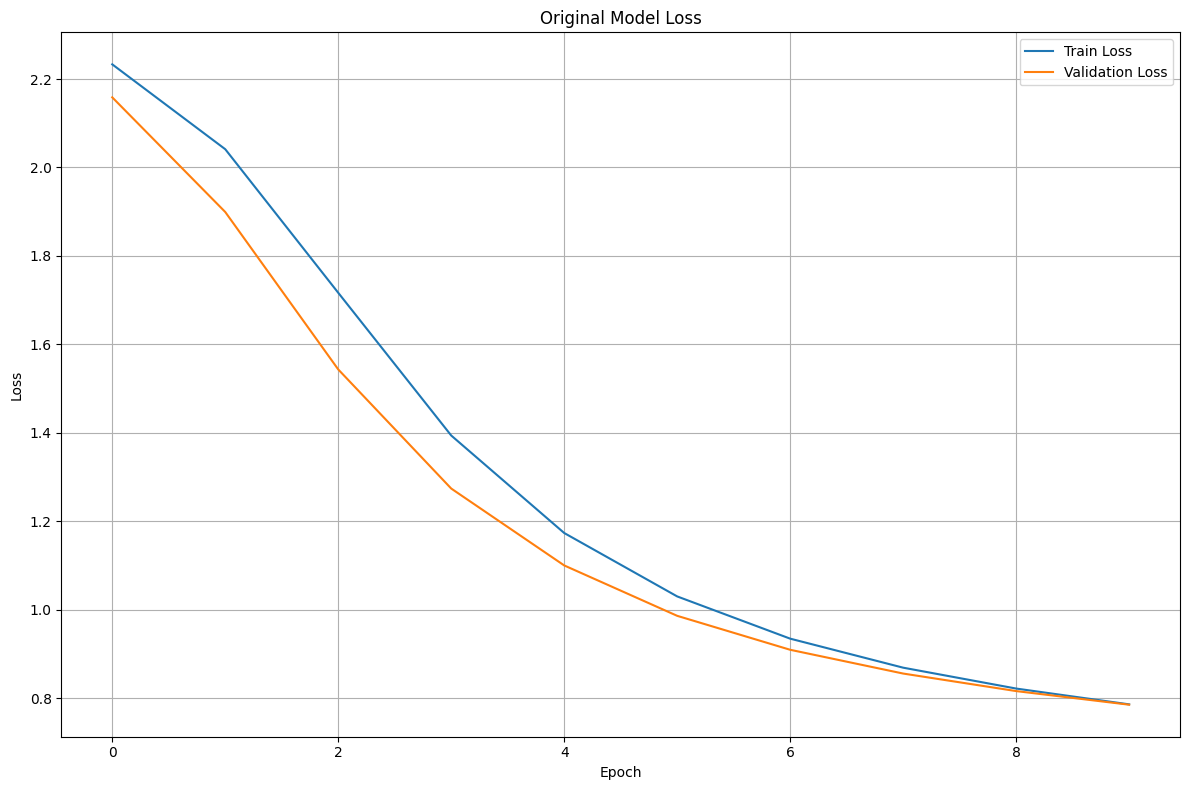

In [9]:
train_losses = []
val_losses = []

epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss = test(test_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
print("Done!")

plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Original Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('original_model_loss_plot.png')
plt.show()

Read more about [Training your model](optimization_tutorial.html).


------------------------------------------------------------------------


Saving Models
=============

A common way to save a model is to serialize the internal state
dictionary (containing the model parameters).


In [10]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Loading Models
==============

The process for loading a model includes re-creating the model structure
and loading the state dictionary into it.


In [11]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

This model can now be used to make predictions.


In [12]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Read more about [Saving & Loading your
model](saveloadrun_tutorial.html).


Epoch 1
-------------------------------
loss: 0.099520  [   64/60000]
loss: 0.134497  [ 6464/60000]
loss: 0.071047  [12864/60000]
loss: 0.137324  [19264/60000]
loss: 0.100071  [25664/60000]
loss: 0.095739  [32064/60000]
loss: 0.130677  [38464/60000]
loss: 0.126400  [44864/60000]
loss: 0.115203  [51264/60000]
loss: 0.103062  [57664/60000]
Test Error: 
 Accuracy: 70.1%, Avg loss: 0.115616 

Epoch 2
-------------------------------
loss: 0.099520  [   64/60000]
loss: 0.134497  [ 6464/60000]
loss: 0.071047  [12864/60000]
loss: 0.137324  [19264/60000]
loss: 0.100071  [25664/60000]
loss: 0.095739  [32064/60000]
loss: 0.130677  [38464/60000]
loss: 0.126400  [44864/60000]
loss: 0.115203  [51264/60000]
loss: 0.103062  [57664/60000]
Test Error: 
 Accuracy: 70.1%, Avg loss: 0.115616 

Epoch 3
-------------------------------
loss: 0.099520  [   64/60000]
loss: 0.134497  [ 6464/60000]
loss: 0.071047  [12864/60000]
loss: 0.137324  [19264/60000]
loss: 0.100071  [25664/60000]
loss: 0.095739  [32064/600

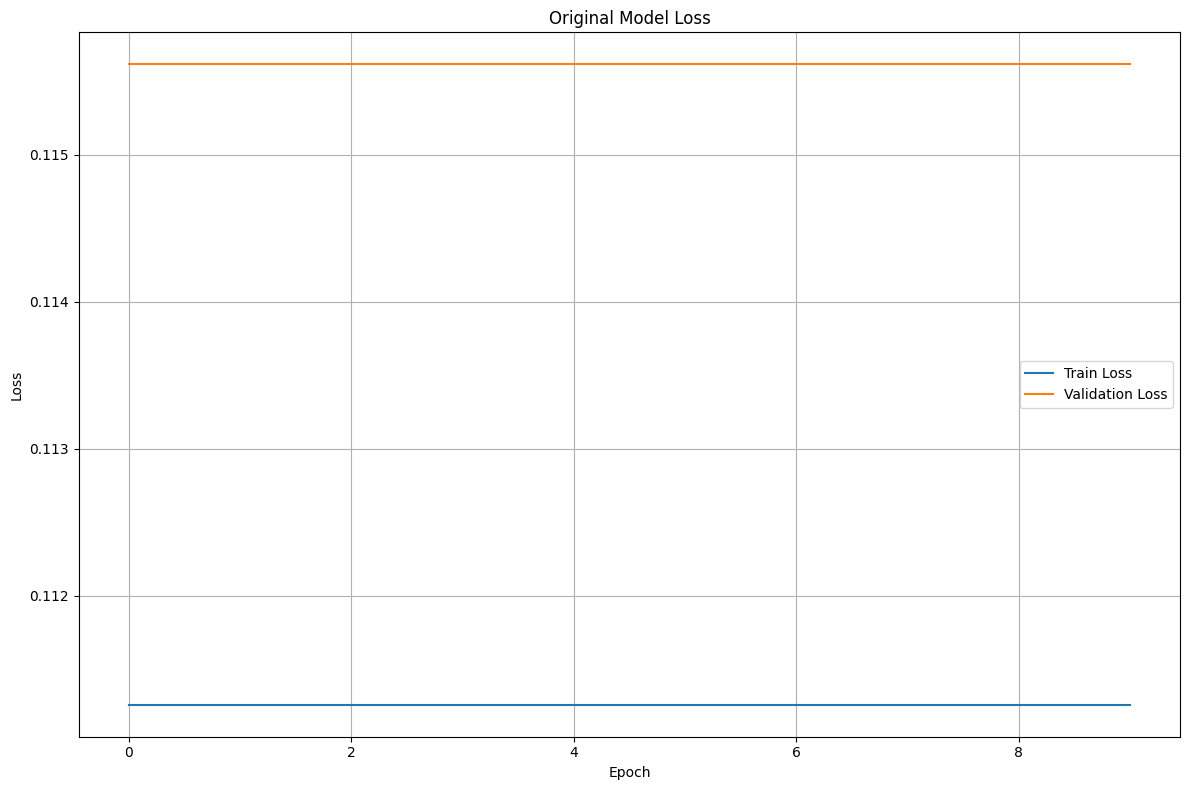

Saved PyTorch Model State to model_2.pth


In [38]:
loss_fn = nn.MultiMarginLoss()

train_losses = []
val_losses = []

epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss = test(test_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
print("Done!")

plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Original Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('new_model_loss_plot.png')
plt.show()

torch.save(model.state_dict(), "model_2.pth")
print("Saved PyTorch Model State to model_2.pth")

SimpleCNN(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=6272, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)
[CNN] Epoch 1
-------------------------------
loss: 2.304408  [   64/60000]
loss: 2.246220  [ 6464/60000]
loss: 2.179647  [12864/60000]
loss: 2.156558  [19264/60000]
loss: 2.052373  [25664/60000]
loss: 1.997742  [32064/60000]
loss: 1.928145  [38464/60000]
loss: 1.841449  [44864/60000]
loss: 1.753538  [51264/60000]
loss: 1.639481  [57664/60000]
Test Error: 
 Accuracy: 63.8%, Avg loss: 1.619861 

[CNN] Epoch 2
-------------------------------
loss: 1.653781  [   64/60000]
loss: 1.600607  [ 6464/60000]
loss: 1.401632  [12864/60000]
loss: 1.460068  [19264/60000]
loss: 1.237280  [25664/60000]
loss:

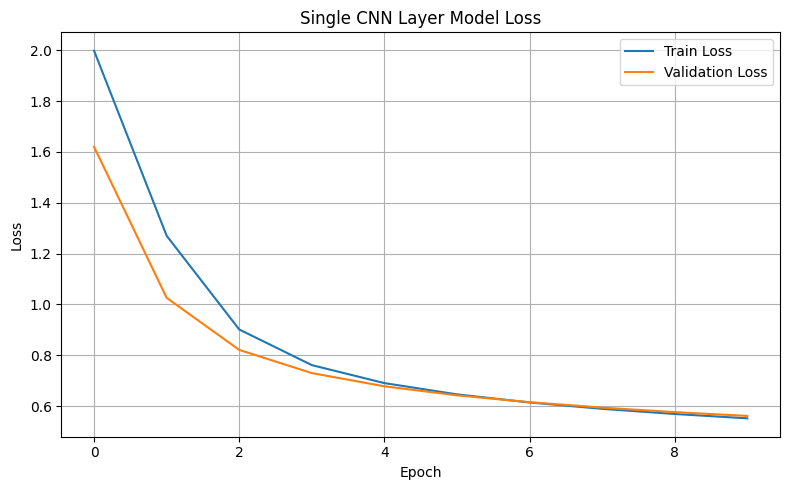

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1 input channel (grayscale), 32 filters
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28 -> 14x14
            nn.Flatten(),
            nn.Linear(32 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.conv_stack(x)

cnn_model = SimpleCNN().to(device)
print(cnn_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=1e-3)

# Training and evaluation
cnn_train_losses = []
cnn_val_losses = []

for t in range(epochs):
    print(f"[CNN] Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, cnn_model, loss_fn, optimizer)
    val_loss = test(test_dataloader, cnn_model, loss_fn)
    cnn_train_losses.append(train_loss)
    cnn_val_losses.append(val_loss)

# Save model
torch.save(cnn_model.state_dict(), "single_cnn_model.pth")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(cnn_train_losses, label='Train Loss')
plt.plot(cnn_val_losses, label='Validation Loss')
plt.title('Single CNN Layer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('single_cnn_model_loss_plot.png')
plt.show()


#### Observations

* **Model 1:** CrossEntropyLoss

Slower convergence than CNN model

* **Model 2:** MultiMarginLoss

Loss never decreases, model never converges. Perhaps, the loss function wasn't suited for the task.

* **Model 3:** CNN Model

Faster convergence than both above models